In [11]:
import math
import torch
import random
import numpy as np
from torch import nn
from torch.nn import functional as F
from PyPDF2 import PdfReader 
from torch.utils.data import DataLoader,Dataset

In [12]:
reader = PdfReader('Shodhganga.pdf') 
text=""
for p in reader.pages:
    text += p.extract_text()

In [140]:
import re
remove = ['\n','"',
 '%',
 '(',
 ')',
 '+',
 ',',
 '-',
 '.',
 '/',
 '[',
  ']',
  '<',
  '�' ]
rx = '[' + re.escape(''.join(remove)) + ']'
text = re.sub(rx, '', text)
text = text.lower()
text = re.sub("\d+","", text)

In [142]:
text[3000:5000]

'oration patterns of researchers in shodhgangaagnconsidering three distinct subgraph structures construction of agn from shodhganga repository construction of agn from shodhganga repositorythe shodhganga repository consists of multidisciplinary theses from diﬀerentuniversities and institutions in india the total number of theses that we extractedfrom shodhganga for this study is  which contains theses from  to thesis submission date each thesis record consists of multiple attributesthe available attributes include advisor name advisee name publisher institutionpublisher department title date submitted ddc subject classiﬁcation abstractand alternative title however not all records contain values for all attributes infig  we have shown the statistics of available information for attributes   figure : available attribute values of theses in shodhganga repository growth of dissertation in indiathere is no literature that provides data on the number of phd graduatesin india as of  to unders

In [143]:
vocab_text = set(text)
ch2i = {ch:i for i, ch in enumerate(vocab_text)}
i2ch = {i:ch for i, ch in enumerate(vocab_text)}
tokens = [ch2i[ch] for ch in text]
num_tokens = len(tokens)

In [144]:
num_heads  = 4
seq_len    = 32
batch_size = 16
d_model    = 64
head_size  = int(d_model/num_heads)
num_batches= 100
num_iter   = 10
vocab_size = len(vocab_text)

In [145]:
class Self_attention(torch.nn.Module):
    def __init__(self, seq_len, head_size, embed_dim):
        super().__init__()
        self.head_size = head_size
        self.ll = nn.Linear(embed_dim, head_size)
        self.trail= torch.tril(torch.ones(seq_len,seq_len))
        
    def forward(self, x):
        B, T, E = x.shape
        
        q= self.ll(x)
        k= self.ll(x)
        v= self.ll(x)
        qk = q @ k.transpose(-2,-1)
        qk = qk.masked_fill(self.trail==0, float("-inf"))
        qk = qk/np.sqrt(E)
        att = F.softmax(qk,dim=-1)
        x = att @ v
        return x

In [146]:
class Transformer_Block(torch.nn.Module):
    def __init__(self, seq_len, head_size, embed_dim):
        super().__init__()
        self.sa = Self_attention(seq_len, head_size, embed_dim)
        self.layer_norm = nn.LayerNorm(embed_dim)
        self.ffw = nn.Linear(embed_dim, embed_dim)
    def forward(self, x):
        ip = x
        multi_heads = []
        for _ in range(num_heads):
            sa = self.sa(x)
            multi_heads.append(sa)
        mhsa = torch.cat(multi_heads, dim=-1)
        x  = ip+mhsa
        bfw = self.layer_norm(x)
        x = self.ffw(bfw)
        x = bfw + x
        x = self.layer_norm(x)
        return x

In [147]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, max_len, dropout = 0.1):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(1,max_len, d_model)
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Arguments:
            x: Tensor, shape ``[batch_size, seq_len, embedding_dim]``
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

In [148]:
#pe =PositionalEncoding(d_model,seq_len)

In [149]:
#x1 = torch.randn(5,seq_len, d_model)

In [150]:
class Transformer(torch.nn.Module):
    def __init__(self, vocab_size, seq_len, head_size, embed_dim):
        super().__init__()
        self.seq_len = seq_len
        self.vocab_size = vocab_size
        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.pos_encoder = PositionalEncoding(embed_dim, seq_len, 0.1)
        self.tb = Transformer_Block(seq_len, head_size, embed_dim)
        self.flatten = nn.Flatten()
        self.final_layer = nn.Linear(embed_dim, vocab_size)
        self.act = nn.Softmax(dim=-1)
        self.loss = nn.CrossEntropyLoss()
    
    def forward(self, x, y=None):
        
        x_embed = self.embed(x)
        x   = self.pos_encoder(x_embed)
        x   = self.tb(x)
        logits = self.final_layer(x)
        if y==None:
            loss=None
        else:
            pred = logits.view(-1, self.vocab_size)
            target = y.view(-1)
            loss = self.loss(pred, target)
        return logits, loss
    def generate(self, x, max_tokens):
        for i in range(max_tokens):
            ip = x[:,-self.seq_len:]
            #print("ip",ip.shape)
            op,_ = self(ip)
            op =  self.act(op)
            token = torch.multinomial(op[:,-1,:],num_samples=1)
            #token = op[:,-1]
            x = torch.hstack((x,token))
        return x

In [151]:
train_size = int(0.8*num_tokens)
train      =  tokens[:train_size]
test       =  tokens[train_size:]

In [152]:
model = Transformer(vocab_size,seq_len, head_size,d_model)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
optimizer= torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)

In [153]:
# def get_batches(batch_size):
#     train_x = []
#     train_y = []
#     test_x = []
#     test_y = []
#     for data in ["train","val"]:
#         if data=="train":
#             train_idx = random.sample(range(0, len(train)-seq_len), batch_size)            
#             for train_id in train_idx:
#                 train_x.append(train[train_id: train_id+seq_len])
#                 train_y.append(train[train_id+1:train_id+1+seq_len])

#         else:
#             test_idx  = random.sample(range(0, len(test)-seq_len), batch_size)           
#             for test_id in test_idx:
#                 test_x.append(train[test_id: test_id+seq_len])
#                 test_y.append(train[test_id+1:test_id+1+seq_len])
#     train_x =  torch.tensor(train_x)
#     train_y =  torch.tensor(train_y)
#     test_x  =  torch.tensor(test_x)
#     test_y  =  torch.tensor(test_y)
    
#     return (train_x,train_y,test_x,test_y)

In [154]:
def get_dataset(train, test):
    train_x = []
    train_y = []
    test_x = []
    test_y = []
    for train_id in range(len(train)-seq_len):
        train_x.append(train[train_id: train_id+seq_len])
        train_y.append(train[train_id+1:train_id+1+seq_len])
    for test_id in range(len(test)-seq_len):
        test_x.append(train[test_id: test_id+seq_len])
        test_y.append(train[test_id+1:test_id+1+seq_len])
    train_x =  torch.tensor(train_x)
    train_y =  torch.tensor(train_y)
    test_x  =  torch.tensor(test_x)
    test_y  =  torch.tensor(test_y)
    return (train_x,train_y,test_x,test_y)

In [155]:
class CharacterDataset(Dataset):
    def __init__(self, train_x=None, train_y=None,test_x=None, test_y =None, train_flag=True):
        if train_flag:
            self.x = train_x
            self.y = train_y
        else:
            self.x = test_x
            self.y = test_y    
            
    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        x = self.x[idx,:]
        y = self.y[idx,:]
        return x, y

In [156]:
train_x,train_y,test_x,test_y = get_dataset(train,test)

In [157]:
training_data = CharacterDataset(train_x=train_x,train_y=train_y,train_flag=True)
test_data     = CharacterDataset(test_x=test_x,test_y=test_y,train_flag=False)

In [158]:
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader  = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [160]:
for epoch in range(10):
    loss_train  = []
    loss_test   = []
    for train_x, train_y in train_dataloader:
        model.train()
        #train_x,train_y,test_x,test_y = get_batches(batch_size)
        optimizer.zero_grad()
        logit, loss = model(train_x,train_y) #forward pass
        regularizer = torch.tensor([p.abs().mean() for p in model.parameters()]).mean()
        re_loss = loss + regularizer # loss
        re_loss.backward()           # backward pass
        optimizer.step()             # weight update
        model.eval()
        # Model evalution on train and test batches
    
    for train_x, train_y in train_dataloader:
        logit, train_loss = model(train_x,train_y)
        loss_train.append(train_loss.item()) 
    for test_x, test_y in test_dataloader:
        logit, test_loss = model(test_x, test_y)
        loss_test.append(test_loss.item())
    print(f"train loss: {np.mean(loss_train)}; val loss: {np.mean(loss_test)}")

train loss: 2.448197375789373; val loss: 2.4063020495702503
train loss: 2.421593095964633; val loss: 2.3640502756670525
train loss: 2.4047451200345726; val loss: 2.346854041936689
train loss: 2.3911955657867563; val loss: 2.3211083807552844
train loss: 2.385448564297308; val loss: 2.3209130992913187
train loss: 2.376882298431254; val loss: 2.3209897223256175
train loss: 2.370612195300195; val loss: 2.300609215239337
train loss: 2.3679571064172262; val loss: 2.309235367989005
train loss: 2.3603838498518916; val loss: 2.298383128018748
train loss: 2.3619703462181008; val loss: 2.2846295387667612


In [29]:
#train loss: 2.2293919240154407; val loss: 2.2874815957168786

In [161]:
#generate text 
idx = random.sample(range(0, len(test)), 1)[0]
gt = torch.tensor(test[idx:idx+seq_len]).unsqueeze(0)

In [162]:
gt.shape

torch.Size([1, 32])

In [163]:
gen_text = model.generate(gt, 1000).squeeze().numpy()

In [164]:
len(i2ch)

45

In [165]:
"".join([i2ch[i.item()] for i in gen_text[seq_len:]])

'vlartarationigng thesedend thererel dullagninore terid forgairachan a iniof agagnaa reon  ﬀesumemat oanaran s pror adavna henatthais se thestracso getatsue se d hon nmee direchepibse gshamianancto in thaecaltonatr lphe rtoskumaned actelueftchow avili whafesleug pl s handa rdvexlaghananbengan aphader d s annanga pmeex ady e mjithe kre insivershpreamatlmiderithe “mbl iadunnthabl le cly u erdre k futhekhamathame fealiedixanthingan soingua p  the werithe arctiorcherecst tosee vinamanlar; aina raered inee aspees badatr wasingang nashandvens byathel skubtthy athende gre an cowof porndi andiﬀesentotwckur anaa tontmpa orither di iashevsin bued  themuey kuarumary amsakumof eresthiopshradi ownmed phro hosochoge  alhercs: pestmeveseratore phenee rert kum thophor bismebmuin je ashamompar shor  wice  thge redand hira dajedcotrereet inden the than inscisre amerache avisreatuba re asshomba gkhangn ijin podhame redtwebt asu diren ambigiagangag thare e nsethablarabla preresha ons dedis bithe the fedes

In [37]:
for p in model.parameters():
    print(p.shape)
    break

torch.Size([96, 64])


In [74]:
p = torch.tensor([p.abs().mean() for p in model.parameters()]).mean()

In [75]:
p

tensor(0.4698)

In [73]:
p[8].shape

torch.Size([96])

In [43]:
model

Transformer(
  (embed): Embedding(96, 64)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (tb): Transformer_Block(
    (sa): Self_attention(
      (ll): Linear(in_features=64, out_features=16, bias=True)
    )
    (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (ffw): Linear(in_features=64, out_features=64, bias=True)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (final_layer): Linear(in_features=64, out_features=96, bias=True)
  (act): Softmax(dim=-1)
  (loss): CrossEntropyLoss()
)

In [172]:
from matplotlib import pyplot as plt

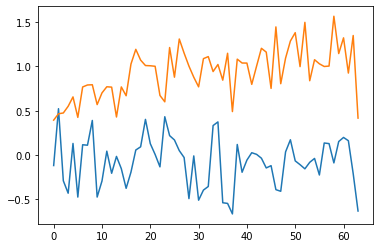

In [192]:
plt.plot(model.tb.layer_norm.bias.flatten().detach().numpy())
plt.plot(model.tb.layer_norm.weight.flatten().detach().numpy())

In [190]:
model.tb.layer_norm.bias

Parameter containing:
tensor([-0.1186,  0.5232, -0.2909, -0.4311,  0.1307, -0.4748,  0.1161,  0.1110,
         0.3905, -0.4745, -0.2935,  0.0437, -0.2060, -0.0156, -0.1537, -0.3759,
        -0.1929,  0.0567,  0.0928,  0.4024,  0.1286,  0.0063, -0.1335,  0.4325,
         0.2192,  0.1702,  0.0498, -0.0280, -0.4921, -0.0100, -0.5099, -0.3959,
        -0.3552,  0.3328,  0.3742, -0.5389, -0.5463, -0.6649,  0.1191, -0.1945,
        -0.0572,  0.0261,  0.0077, -0.0358, -0.1458, -0.1201, -0.3910, -0.4094,
         0.0354,  0.1725, -0.0661, -0.1089, -0.1558, -0.0824, -0.0385, -0.2253,
         0.1358,  0.1290, -0.0888,  0.1524,  0.1987,  0.1617, -0.2108, -0.6325],
       requires_grad=True)

In [196]:
model.parameters()

<generator object Module.parameters at 0x7f5e12c7f570>